# LINQ solar panel simulation with Python

The purpose of this notebook is to create a simulation of the power of the solar panels. By doing this it becomes possible to use predictive control. This can be used to give the inhabitant of the house advice on when to use appliances because it is known how much energy will be generated the next day.

The code below is based on [this tutorial](https://github.com/pvlib/pvlib-python/blob/master/docs/tutorials/forecast_to_power.ipynb).

First we want to import the packages we need.

In [1]:
import datetime # package to handle dates
import numpy as np # numpy to handle arrays
import pandas as pd # pandas to handle dataframes

# needed to show graphs inside this notebook
%matplotlib inline

import matplotlib.pyplot as plt # matplotlib to make plots
import matplotlib as mpl # matplotlib to do other stuff
import seaborn as sns # seaborn to beautify the plots

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

# finally, we import the pvlib library
import pvlib
from pvlib.forecast import GFS

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/pvlib/forecast.py:22: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'module, or the module may be separated into its own package.')


## Setting up some variables
We need some variables to start with. The location data we need is as follows:

|name|purpose|our value|
|----|-------|---------|
|span|Span of forecast in days|7 days|
|lat|Latitude of building location|24.773104 (SDME plot)|
|lon|Longitude of building location|55.368243 (SDME plot)|
|alt|Altitude of building location|105 (SDME plot)|
|timezone|Timezone of building location|Asia/Dubai (SDME plot)|
|frequency|Frequency of model generation| Every 1 minute|

In [2]:
latitude = 24.773104
longitude = 55.368243
altitude = 105
timezone = 'Asia/Dubai'
span = 7
start_date = datetime.datetime.now()
end_date = start_date + datetime.timedelta(days=7)
frequency = '1Min'

Now we can create a times array with all the datetimes within the period.

In [3]:
times = pd.date_range(start=start_date, end=end_date, freq=frequency)
localised_times = times.tz_localize(timezone)
print(localised_times)

DatetimeIndex(['2017-12-21 11:43:18.125621+04:00',
               '2017-12-21 11:44:18.125621+04:00',
               '2017-12-21 11:45:18.125621+04:00',
               '2017-12-21 11:46:18.125621+04:00',
               '2017-12-21 11:47:18.125621+04:00',
               '2017-12-21 11:48:18.125621+04:00',
               '2017-12-21 11:49:18.125621+04:00',
               '2017-12-21 11:50:18.125621+04:00',
               '2017-12-21 11:51:18.125621+04:00',
               '2017-12-21 11:52:18.125621+04:00',
               ...
               '2017-12-28 11:34:18.125621+04:00',
               '2017-12-28 11:35:18.125621+04:00',
               '2017-12-28 11:36:18.125621+04:00',
               '2017-12-28 11:37:18.125621+04:00',
               '2017-12-28 11:38:18.125621+04:00',
               '2017-12-28 11:39:18.125621+04:00',
               '2017-12-28 11:40:18.125621+04:00',
               '2017-12-28 11:41:18.125621+04:00',
               '2017-12-28 11:42:18.125621+04:00',
            

## Solar position

The easiest thing we can do is calculating the solar position based on the longitude, latitude and the altitude. In the graph below we have the angle of the sun during the contest period.

In [4]:
solar_positions = pvlib.solarposition.get_solarposition(times, latitude, longitude)
print(solar_positions.head())

                            apparent_elevation  apparent_zenith     azimuth  \
2017-12-21 11:43:18.125621           20.545356        69.454644  230.192432   
2017-12-21 11:44:18.125621           20.371238        69.628762  230.351135   
2017-12-21 11:45:18.125621           20.196726        69.803274  230.509157   
2017-12-21 11:46:18.125621           20.021825        69.978175  230.666501   
2017-12-21 11:47:18.125621           19.846538        70.153462  230.823172   

                            elevation  equation_of_time     zenith  
2017-12-21 11:43:18.125621  20.501015          1.823370  69.498985  
2017-12-21 11:44:18.125621  20.326495          1.823024  69.673505  
2017-12-21 11:45:18.125621  20.151574          1.822678  69.848426  
2017-12-21 11:46:18.125621  19.976256          1.822332  70.023744  
2017-12-21 11:47:18.125621  19.800545          1.821986  70.199455  


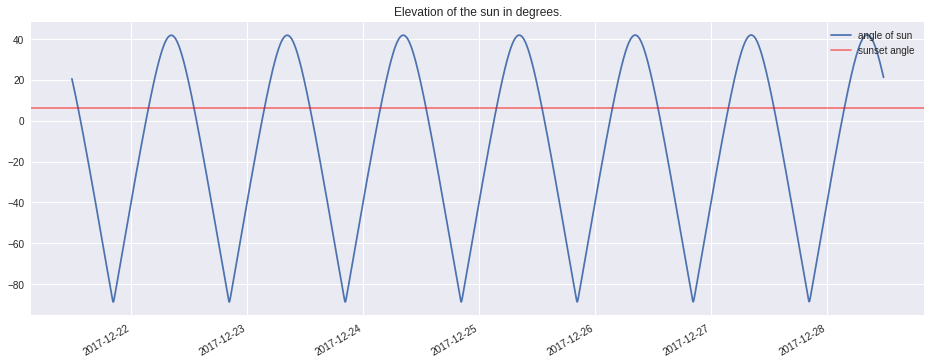

In [5]:
fig, ax = plt.subplots()
ax.plot(solar_positions['elevation'], label='angle of sun')

ax.set_title('Elevation of the sun in degrees.')

plt.axhline(6, color='red', label='sunset angle', alpha=.5)
plt.legend(loc='upper right')
fig.autofmt_xdate()

## Add weather forecasting model
The forecasting model used is the GFS model. This model runs four times a day and produces forecasts for up to 16 days in advance.

In [6]:
forecast_model = GFS()
raw_data = forecast_model.get_data(latitude, longitude, start_date, end_date)
print(raw_data.head())

                           Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average  \
2017-12-21 12:00:00+00:00                                              580.0                    
2017-12-21 15:00:00+00:00                                               60.0                    
2017-12-21 18:00:00+00:00                                               30.0                    
2017-12-21 21:00:00+00:00                                                0.0                    
2017-12-22 00:00:00+00:00                                                0.0                    

                           Temperature_surface  \
2017-12-21 12:00:00+00:00           302.098389   
2017-12-21 15:00:00+00:00           295.618469   
2017-12-21 18:00:00+00:00           293.598022   
2017-12-21 21:00:00+00:00           292.000031   
2017-12-22 00:00:00+00:00           290.799988   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2017-12-21 12:00:00+00:

Prepare data and make some conversitions

In [7]:
data = forecast_model.process_data(raw_data)
# Proces the data
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2017-12-21 12:00:00+00:00  28.948395    6.499778  239.737474  521.804148   
2017-12-21 15:00:00+00:00  22.468475    6.898372    0.000000    0.000000   
2017-12-21 18:00:00+00:00  20.448029    5.377725    0.000000    0.000000   
2017-12-21 21:00:00+00:00  18.850037    4.406333    0.000000    0.000000   
2017-12-22 00:00:00+00:00  17.649994    3.940804    0.000000    0.000000   

                                 dhi  total_clouds  low_clouds  mid_clouds  \
2017-12-21 12:00:00+00:00  82.512269           0.0         0.0         0.0   
2017-12-21 15:00:00+00:00   0.000000           0.0         0.0         0.0   
2017-12-21 18:00:00+00:00   0.000000           0.0         0.0         0.0   
2017-12-21 21:00:00+00:00   0.000000           0.0         0.0         0.0   
2017-12-22 00:00:00+00:00   0.000000           0.0         0.0         0.0   

                           high_clouds  
2017-12-21 12:00:00+00:00        

### Cloud coverage in Dubai


High clouds: Cirrus (Ci), Cirrocumulus (Cc), and Cirrostratus (Cs). They are typically thin and white in appearance, but can appear in a magnificent array of colors when the sun is low on the horizon.

Middle clouds: Altocumulus (Ac), Altostratus (As). They are composed primarily of water droplets, however, they can also be composed of ice crystals when temperatures are low enough.

Low clouds: Cumulus (Cu), Stratocumulus (Sc), Stratus (St), and Cumulonimbus (Cb) are low clouds composed of water droplets. 

_Source: http://www.weatheronline.co.uk/cgi-bin/expertcharts?MODELL=gfs&MODELLTYP=1&VAR=lcdc&INFO=1 _

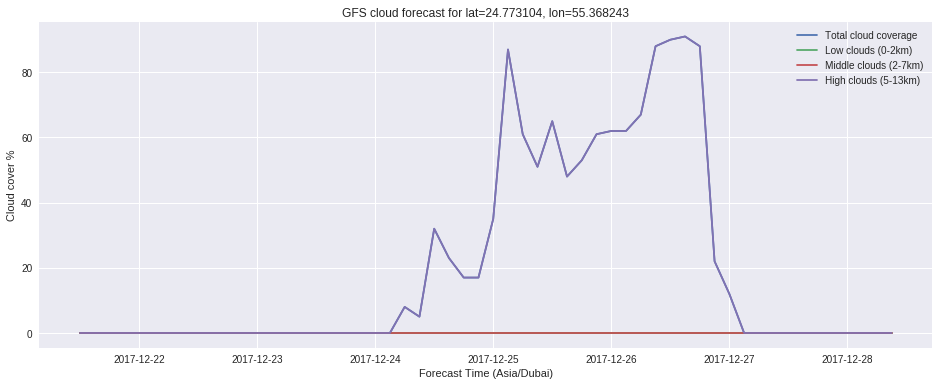

In [8]:
fig, ax = plt.subplots()
#ax.plot(data[['total_clouds', 'low_clouds', 'mid_clouds', 'high_clouds']])
ax.plot(data['total_clouds'], label='Total cloud coverage')
ax.plot(data['low_clouds'], label='Low clouds (0-2km)')
ax.plot(data['mid_clouds'], label='Middle clouds (2-7km)')
ax.plot(data['high_clouds'], label='High clouds (5-13km)')
ax.set_ylabel('Cloud cover %')
ax.set_xlabel('Forecast Time ({})'.format(timezone))
ax.set_title('GFS cloud forecast for lat={}, lon={}'.format(latitude, longitude))
ax.legend()

### Use the solar positions and the cloud coverage forecast

In solar energy applications, the following parameters are commonly used in practice:

- Direct Normal Irradiation/Irradiance (DNI) is the component that is involved in thermal (concentrating solar power, CSP) and photovoltaic concentration technology (concentrated photovoltaic, CPV).
- Global Horizontal Irradiation/Irradiance (GHI) is the sum of direct and diffuse radiation received on a horizontal plane. GHI is a reference radiation for the comparison of climatic zones; it is also essential parameter for calculation of radiation on a tilted plane.
- Global Tilted Irradiation/Irradiance (GTI), or total radiation received on a surface with defined tilt and azimuth, fixed or sun-tracking. This is the sum of the scattered radiation, direct and reflected. It is a reference for photovoltaic (PV) applications, and can be occasionally affected by shadow.

![https://firstgreenconsulting.files.wordpress.com/2012/04/dni-dhi-ghi.jpg](https://firstgreenconsulting.files.wordpress.com/2012/04/dni-dhi-ghi.jpg)

_Source: https://solargis.com/support/methodology/solar-radiation-modeling/ _

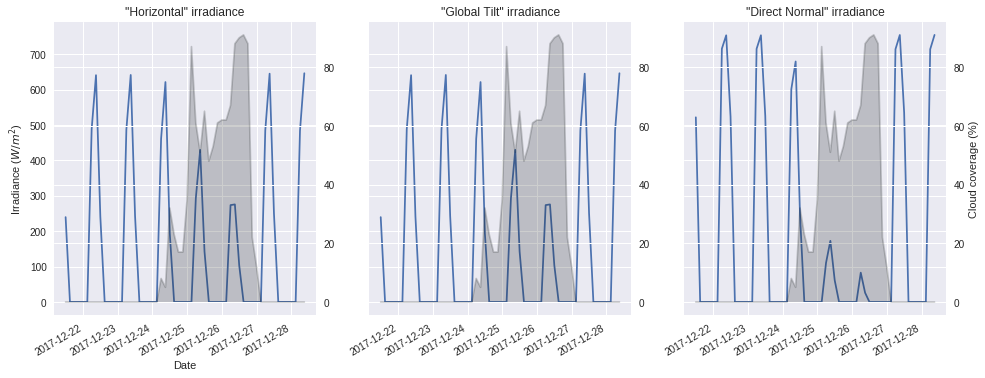

In [85]:
cloud_cover = data
irradiance = forecast_model.cloud_cover_to_irradiance(cloud_cover['total_clouds'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
ax1.plot(irradiance['ghi'])
ax1.set_title('"Horizontal" irradiance')
ax1.set_ylabel('Irradiance ($W/m^2$)')

ax2.plot(irradiance['ghi'])
ax2.set_title('"Global Tilt" irradiance')

ax3.plot(irradiance['dni'])
ax3.set_title('"Direct Normal" irradiance')

twin_ax0 = ax1.twinx()
twin_ax1 = ax2.twinx()
twin_ax2 = ax3.twinx()
twin_ax2.set_ylabel('Cloud coverage (%)')

ax1.get_shared_y_axes().join(twin_ax0, twin_ax1, twin_ax2)

twin_ax0.plot(cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)
twin_ax0.fill(cloud_cover.index, cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)
twin_ax1.plot(cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)
twin_ax1.fill(cloud_cover.index, cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)
twin_ax2.plot(cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)
twin_ax2.fill(cloud_cover.index, cloud_cover['total_clouds'], 'xkcd:almost black', alpha=.2)

fig.autofmt_xdate()

### Graphs displayed above
In the graphs displayed above the grey fields on the background is the cloud coverage in percentage. The blue lines is the expected irradiance in W/m2. It is visible that the expected energy generation is smaller when cloud coverage is higher. This can be used to advice the user on when to use electrical appliances.

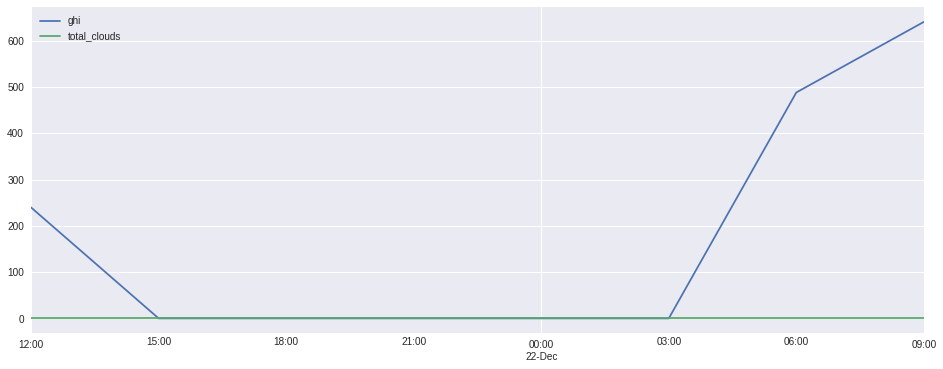

In [113]:
# get next 24 hour of data
today = start_date
today_end = today + datetime.timedelta(days=1)
today_data = cloud_cover.loc[today:today_end][['ghi', 'total_clouds']]

today_data.plot()